# 📊 TikTok Engagement Analysis

Welcome to my data analysis project where I explore my personal TikTok usage patterns in relation to weather conditions and significant real-world events. This notebook walks through various datasets I decided to merge and visualize, that may influence my personal daily TikTok consumption.

**Note:** I have extended my TikTok data in this last phase; it now includes a longer time period for more comprehensive analysis.

## 🧩 Notebook Overview

This notebook is divided into 8 key parts:

1. **📱 Processing TikTok App Data**  
   - Extracted and cleaned raw data gathered from the TikTok app (e.g., watch history).  
   - Prepared the data for engagement attributes like video count and estimated usage duration.

2. **☁️ Weather Data Integration**  
   - Weather data was preprocessed in advance using data collected via [Visual Crossing](https://www.visualcrossing.com/weather-query-builder/).  
   - It includes key day-level metrics such as temperature, humidity, precipitation, and more.  
   - Since it was already clean and complete, it required no additional processing in this notebook.

3. **📆 Processing Manually Collected Event Data**  
   - Gathered and processed key cultural, entertainment, and global events that may impact digital habits.  
   - Includes things like award shows, religious events, and academic schedules.

4. **🔗 Merging All Data Sources**  
   - Combined TikTok, weather, and event data into one unified dataset.  
   - In my TikTok data, the days I didn't watch anything have the value 0,  
   - In my Weather data, there is no missing values,  
   - In my events data, everything is gathered manually,  
   - So as a result, I didn't have missing values.

5. **☀️ Weather Data Statistical Summary**  
   - Conducted a statistical analysis of weather-related variables, such as temperature, humidity, and precipitation.  
   - Generated summary statistics like mean, median, and standard deviation to understand how different weather conditions vary over time.  
   - This analysis served as a foundation for further exploration into how weather patterns might influence my TikTok usage.

6. **📈 Creating Visualizations**  
   - Generated visual plots/graphs to identify patterns or anomalies.  
   - Explored potential correlations between various factors and TikTok consumption.

7. **🔍 Hypotheses and Results**  
   - Weather: Testing if weather conditions (like rain) increase usage.  
   - Events: Testing if major events (e.g., award shows) drive usage.  
   - Academics & Schedule: Testing if academic year & schedule on weekdays reduce usage.

8. **🔮 Prediction**  
   - Built predictive models for TikTok usage based on weather, events, and academic schedules.  
   - Evaluated models' performances and summarized key findings.


# 📱 1. TikTok Data Preprocessing

In this section, I begin by loading my original TikTok data, which was obtained directly from the application’s data export. From the full dataset, I extract only the segments relevant to this project — particularly the **watch history**.

**Note:** I will be combining two TikTok datasets to expand the time period covered by this analysis, allowing for a more comprehensive view of my usage patterns.

### 🔍 What I'm Measuring

To gain meaningful insights into my consumption, I focus on two main factors:

- **🎥 Number of Videos Watched**  
  Directly counted from the number of TikTok links in the watch history.

- **⏱️ Estimated Time Spent Watching**  
  Since the app does not provide exact viewing durations, I estimate time spent by assuming each video takes about **15 seconds** to watch. The total is then **converted into hours** by dividing the total seconds by 3600.

This approach allows me to estimate the total viewing time based on the number of videos watched.


In [82]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


with open('original_tikok_data.json', 'r') as file:
    data1 = json.load(file)

#the second data I got from tiktok, so that I could expand my analysis
with open('original_second_tiktok_data.json', 'r') as file:
    data2 = json.load(file)

video_list1 = data1["Your Activity"]["Watch History"]["VideoList"]
video_list2 = data2["Your Activity"]["Watch History"]["VideoList"]
df1 = pd.DataFrame(video_list1)
df2 = pd.DataFrame(video_list2)

#combine both
combined_df = pd.concat([df1, df2], ignore_index=True)

combined_df['Date'] = pd.to_datetime(combined_df['Date'])

#remove duplicates based on Date, since some parts of the two datasets are overlapping
combined_df = combined_df.drop_duplicates(subset=['Date'], keep='first')
combined_df = combined_df.sort_values('Date').reset_index(drop=True) #chronological order
combined_df['Day'] = combined_df['Date'].dt.date

daily_usage = combined_df.groupby('Day').size().reset_index(name='Videos Watched')

#estimate total time in hours (assuming 15 seconds per video)
daily_usage['TikTok Usage (Hours)'] = daily_usage['Videos Watched'] * 15 / 3600
daily_usage = daily_usage.sort_values('Day').reset_index(drop=True)

daily_usage.to_csv('daily_tiktok_data.csv', index=False)

#some information regarding my datasets before and after combination
print(f"Total videos in dataset 1: {len(df1)}")
print(f"Total videos in dataset 2: {len(df2)}")
print(f"Total videos after combining: {len(combined_df)}")
print(f"Date range: {combined_df['Day'].min()} to {combined_df['Day'].max()}")
print("--Until pretty recent--")
print("\nFirst few rows:")
print(daily_usage.head())
print("\nLast few rows:")
print(daily_usage.tail())

Total videos in dataset 1: 26690
Total videos in dataset 2: 30903
Total videos after combining: 37152
Date range: 2024-09-11 to 2025-05-21
--Until pretty recent--

First few rows:
          Day  Videos Watched  TikTok Usage (Hours)
0  2024-09-11             273              1.137500
1  2024-09-12              61              0.254167
2  2024-09-13             316              1.316667
3  2024-09-14              96              0.400000
4  2024-09-15             403              1.679167

Last few rows:
            Day  Videos Watched  TikTok Usage (Hours)
240  2025-05-17             408              1.700000
241  2025-05-18             180              0.750000
242  2025-05-19             283              1.179167
243  2025-05-20             144              0.600000
244  2025-05-21               2              0.008333


---

# ☁️ 2. Weather Data

To understand how environmental conditions may influence my TikTok usage, I incorporated daily weather data into this project.

The data was collected using the [Visual Crossing Weather Query Builder](https://www.visualcrossing.com/weather-query-builder/), which provides detailed, day-level historical weather information.

### 📋 Key Attributes Included:

- `feelslike`: How the temperature feels in °C
- `precip`: Precipitation levels in mm
- `snow` & `snowdepth`: Snowfall and snow accumulation (if any)
- `cloudcover`: Cloud coverage as a percentage
- `uvindex`: UV exposure index
- `general`: A simplified label describing the overall weather condition (e.g., sunny, rainy, cloudy)

Here's a quick look at the structure of the dataset:

| datetime     | feelslike | precip | snow | snowdepth | cloudcover | uvindex | general           |
|--------------|-----------|--------|------|-----------|-------------|---------|-------------------|
| 2024-09-10   | 24.9      | 0      | 0    | 0         | 58.8        | 6       | partly-cloudy-day |
| 2024-09-11   | 25.7      | 8      | 0    | 0         | 53.0        | 6       | rain              |

### 🧼 Preprocessing Note

This dataset was **fully cleaned and preprocessed** before being used here:
- All fields are complete (no missing data).
- Dates are formatted properly for easy merging.
- Columns are already standardized and analysis-ready.

Because of this, there's no additional code or processing required in this step — the dataset is simply loaded and merged in the next section.

---


---

# 📅 3. Events Data Preprocessing

In this section, I processed a manually collected dataset of significant events, stored in a semicolon-separated CSV file. These events represent various cultural, academic, religious, and entertainment moments that may influence my digital behavior.

### 🛠️ Notes in Preprocessing

- The dataset is loaded with `sep=';'` because the default is a comma separator.
- The `Date` column is converted to a proper **datetime** object for easier temporal operations.
- Irrelevant columns such as `"TikTok Links"` and a duplicated `"Day"` column are removed to clean up the dataset.

### 📌 Types of Events

The event data is transformed into two main types:

1. **⏳ Countdown Events**  
   These represent how many days are left *until* or have passed *since* a specific event date. Examples include:
   - Grammy Awards
   - Oscar Awards
   - New Year's Day
   - Nowruz
   - National elections

2. **✅ Boolean Events**  
   These flag whether a particular event occurred on each date. For instance:
   - Paris Fashion Week (on specific dates)
   - Ramadan (spanning a date range)
   - UEFA Champions League match days
   - The academic school year
   - Weekday vs. weekend indicators

This allows me to analyse how factors like a global event or weekend — might affect my TikTok engagement.

---


In [83]:
tiktok_min_date = daily_usage['Day'].min()
tiktok_max_date = daily_usage['Day'].max()

#match the number of rows with tiktok data
date_range = pd.date_range(start=tiktok_min_date, end=tiktok_max_date, freq='D')
df = pd.DataFrame({'Date': date_range})

countdown_events = {
    '2025 Grammy Awards (Countdown)': pd.Timestamp('2025-02-03'),
    '2025 Oscar Awards (Countdown)': pd.Timestamp('2025-03-03'),
    '1404 Nowruz (Countdown)': pd.Timestamp('2025-03-21'),
    '2025 New Year (Countdown)': pd.Timestamp('2025-01-01'),
    '2024 United States presidential election (Countdown)': pd.Timestamp('2024-11-05'),
}
for column, date in countdown_events.items():
    df[column] = (date - df["Date"]).dt.days

# Boolean date ranges
df["2024 Paris Fashion Week (Bool)"] = df["Date"].between("2024-09-23", "2024-10-01").astype(int)
df["2025 Ramazan (Bool)"] = df["Date"].between("2025-03-01", "2025-03-29").astype(int)
df["24/25 School Year (Bool)"] = df["Date"].between("2024-09-23", "2025-06-04").astype(int)

# UEFA Champions League match dates
ucl_dates = [
    '2024-09-17', '2024-09-18', '2024-09-19',
    '2024-10-01', '2024-10-02', '2024-10-22', '2024-10-23',
    '2024-11-05', '2024-11-06', '2024-11-26', '2024-11-27',
    '2024-12-10', '2024-12-11',
    '2025-01-21', '2025-01-22', '2025-01-29',
    '2025-02-11', '2025-02-12', '2025-02-18', '2025-02-19',
    '2025-03-04', '2025-03-05', '2025-03-11', '2025-03-12'
]
ucl_dates = pd.to_datetime(ucl_dates)
df["24/25 UEFA Champions League (Bool)"] = df["Date"].isin(ucl_dates).astype(int)

# Weekday / Weekend
df["Weekday (Bool)"] = (df["Date"].dt.weekday < 5).astype(int)
df["Weekend (Bool)"] = (df["Date"].dt.weekday >= 5).astype(int)

df.to_csv("info_corrected_events_data.csv", index=False, sep=';')
df.head()

,Date,2025 Grammy Awards (Countdown),2025 Oscar Awards (Countdown),1404 Nowruz (Countdown),2025 New Year (Countdown),2024 United States presidential election (Countdown),2024 Paris Fashion Week (Bool),2025 Ramazan (Bool),24/25 School Year (Bool),24/25 UEFA Champions League (Bool),Weekday (Bool),Weekend (Bool)
0,2024-09-11,145,173,191,112,55,0,0,0,0,1,0
1,2024-09-12,144,172,190,111,54,0,0,0,0,1,0
2,2024-09-13,143,171,189,110,53,0,0,0,0,1,0
3,2024-09-14,142,170,188,109,52,0,0,0,0,0,1
4,2024-09-15,141,169,187,108,51,0,0,0,0,0,1


---

### 🔄 Standardizing TikTok Data Format

Before merging all datasets, I thought it would be better all the files share the same structure — particularly the **delimiter** used in the CSV files.

By default, the TikTok data was saved using commas (`,`), whereas the other datasets use semicolons (`;`).  
To ensure consistency across all sources, I re-save the TikTok file with the correct delimiter.

This small adjustment helps avoid parsing issues during the final merge step.

---

In [84]:
tiktok_df = pd.read_csv('daily_tiktok_data.csv', sep=',')

# Save the dataframe to a CSV with a semicolon separator this time
tiktok_df.to_csv('changed_delimiter_daily_tiktok_data.csv', index=False, sep=';')


---

# 🔗 4. Merging All Data Sources

In this step, I combine the cleaned and preprocessed datasets into a single DataFrame for analysis.

### 📋 Datasets

- **TikTok Daily Data**: Contains the number of videos watched and estimated usage time per day.
- **Weather Data**: Collected via an API and includes daily weather features such as temperature, humidity, etc.
- **Events Data**: Manually gathered dataset that includes countdowns and boolean values for significant events and dates.

### ⚙️ How the Merge Works

1. All datasets are aligned using a common column: **`Day`**.
2. The merge is done using a left join.
3. The final merged dataset is saved as a CSV file named:  
   `merged_tiktok_weather_events.csv`

This merged file will be used in the next steps to make visualizations and run analyses that explore how factors (like weather or global events) may influence my daily TikTok behavior.

---

In [85]:
tiktok_df = pd.read_csv('changed_delimiter_daily_tiktok_data.csv', sep=';')

tiktok_df['Day'] = pd.to_datetime(tiktok_df['Day'])

weather_df = pd.read_csv('original_weather_data.csv', sep=';')
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])
weather_df.rename(columns={'datetime': 'Day'}, inplace=True)

merged_df = pd.merge(tiktok_df, weather_df, on='Day', how='left')

events_df = pd.read_csv('info_corrected_events_data.csv', sep=';')
events_df.rename(columns={'Date': 'Day'}, inplace=True)
events_df['Day'] = pd.to_datetime(events_df['Day'])

full_merged_df = pd.merge(merged_df, events_df, on='Day', how='left')

full_merged_df.to_csv('merged_tiktok_weather_events.csv', index=False)
full_merged_df.head()


,Day,Videos Watched,TikTok Usage (Hours),feelslike,precip,snow,snowdepth,cloudcover,uvindex,general,...,2025 Oscar Awards (Countdown),1404 Nowruz (Countdown),2025 New Year (Countdown),2024 United States presidential election (Countdown),2024 Paris Fashion Week (Bool),2025 Ramazan (Bool),24/25 School Year (Bool),24/25 UEFA Champions League (Bool),Weekday (Bool),Weekend (Bool)
0,2024-09-11,273,1.137500,25.7,8.0,0.0,0.0,53.0,6,rain,...,173,191,112,55,0,0,0,0,1,0
1,2024-09-12,61,0.254167,25.5,16.0,0.0,0.0,40.3,7,rain,...,172,190,111,54,0,0,0,0,1,0
2,2024-09-13,316,1.316667,26.1,0.0,0.0,0.0,17.1,7,clear-day,...,171,189,110,53,0,0,0,0,1,0
3,2024-09-14,96,0.400000,27.0,0.0,0.0,0.0,43.3,7,partly-cloudy-day,...,170,188,109,52,0,0,0,0,0,1
4,2024-09-15,403,1.679167,23.5,938.0,0.0,0.0,66.7,4,rain,...,169,187,108,51,0,0,0,0,0,1


# 📊 5. Weather Data Statistical Summary

### Descriptive Statistics:
1.   Mean
2.   Standard Deviation
3.   Min/Max
4.   25%, 50%, 75% Quartiles

### ✅ Output:
Numeric summary for all columns.

---

In [86]:
weather_columns = ['feelslike', 'precip', 'snow', 'snowdepth', 'cloudcover', 'uvindex']
weather_stats = full_merged_df[weather_columns].describe()
weather_stats = weather_stats.round(3)

print("Statistical Summary of Weather Data:")
print(weather_stats)


Statistical Summary of Weather Data:
       feelslike   precip     snow  snowdepth  cloudcover  uvindex
count    245.000  245.000  245.000    245.000     245.000  245.000
mean      11.326   66.918    0.027      0.051      56.408    4.820
std        6.482  195.249    0.164      0.503      26.676    2.504
min       -4.200    0.000    0.000      0.000       0.100    0.000
25%        6.800    0.000    0.000      0.000      37.700    3.000
50%       11.300    0.100    0.000      0.000      61.400    5.000
75%       14.700    8.000    0.000      0.000      81.200    7.000
max       27.000  989.000    1.500      6.300      99.100   10.000


---

# 📊 6. Visual Exploration of TikTok Usage Patterns

In this section, I begin analyzing the merged dataset through a series of exploratory visualizations. The goal is to find potential patterns and relationships between my TikTok activity and a variety of external factors such as weather, time context (weekday/weekend), school calendar, and major global events.

This stage is **exploratory in nature** and sets the foundation for deeper analysis later on.

Each visualization helps to go over my hypotheses about how external factors might shape or influence my digital behavior.


---

## 🔧 Setup: Load Dataset

First, we load the merged dataset.

---


In [87]:
df = pd.read_csv('merged_tiktok_weather_events.csv')
df['Day'] = pd.to_datetime(df['Day'])

## 📈 TikTok Usage Trends Over Time
How has my TikTok usage changed throughout the semester?
This line graph shows the daily usage in hours.⏳📱

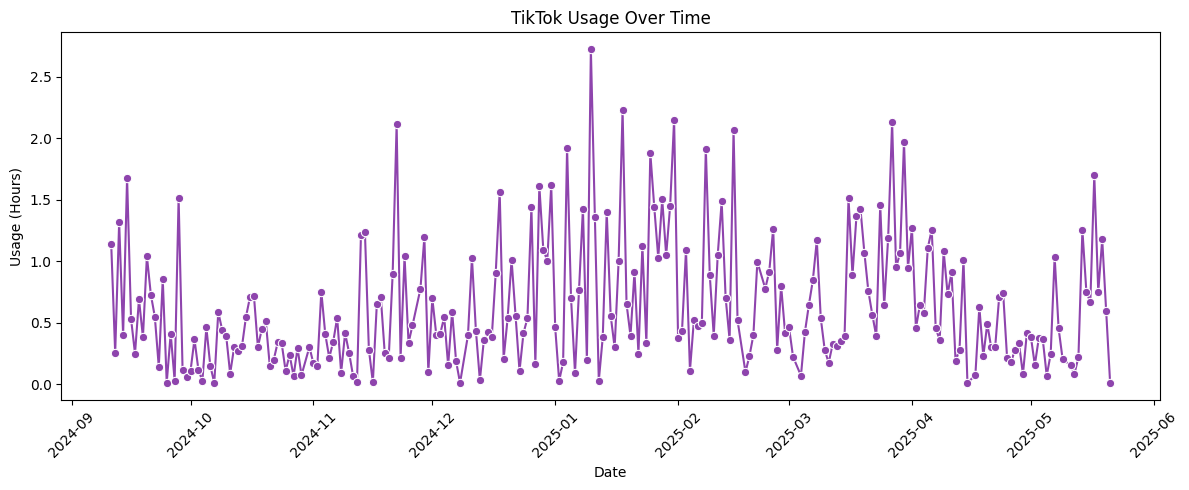

In [88]:
plt.figure(figsize=(12, 5))
sns.lineplot(x='Day', y='TikTok Usage (Hours)', data=df, marker='o', color='#8e44ad')

plt.title("TikTok Usage Over Time")
plt.xlabel("Date")
plt.ylabel("Usage (Hours)")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 🔍 General Correlation with TikTok Usage
What factors are most strongly correlated with my TikTok usage? 📊🔍


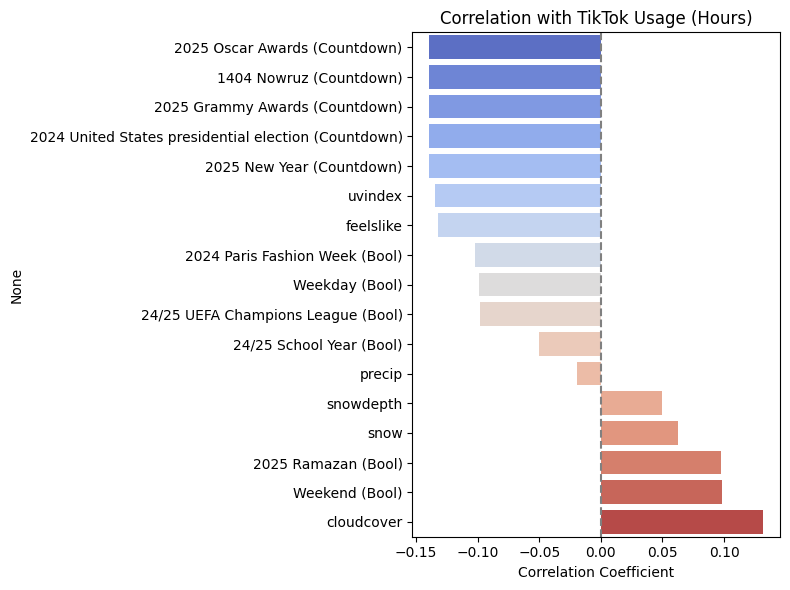

In [89]:
# Correlations with TikTok Usage (used .corr())
corr_series = df.corr(numeric_only=True)['TikTok Usage (Hours)'].drop(['TikTok Usage (Hours)', 'Videos Watched'])
corr_series = corr_series.sort_values()

plt.figure(figsize=(8, 6))
sns.barplot(x=corr_series.values, y=corr_series.index, hue=corr_series.index, palette='coolwarm', orient='h', legend=False)
plt.title("Correlation with TikTok Usage (Hours)")
plt.xlabel("Correlation Coefficient")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


## 🌦️ TikTok Usage with Detailed Weather Features
How do weather conditions impact my TikTok usage?
These scatter plots show the relationship between various weather features (such as temperature, precipitation, snow, and UV index) and my TikTok consumption. 🌧️🌞📱

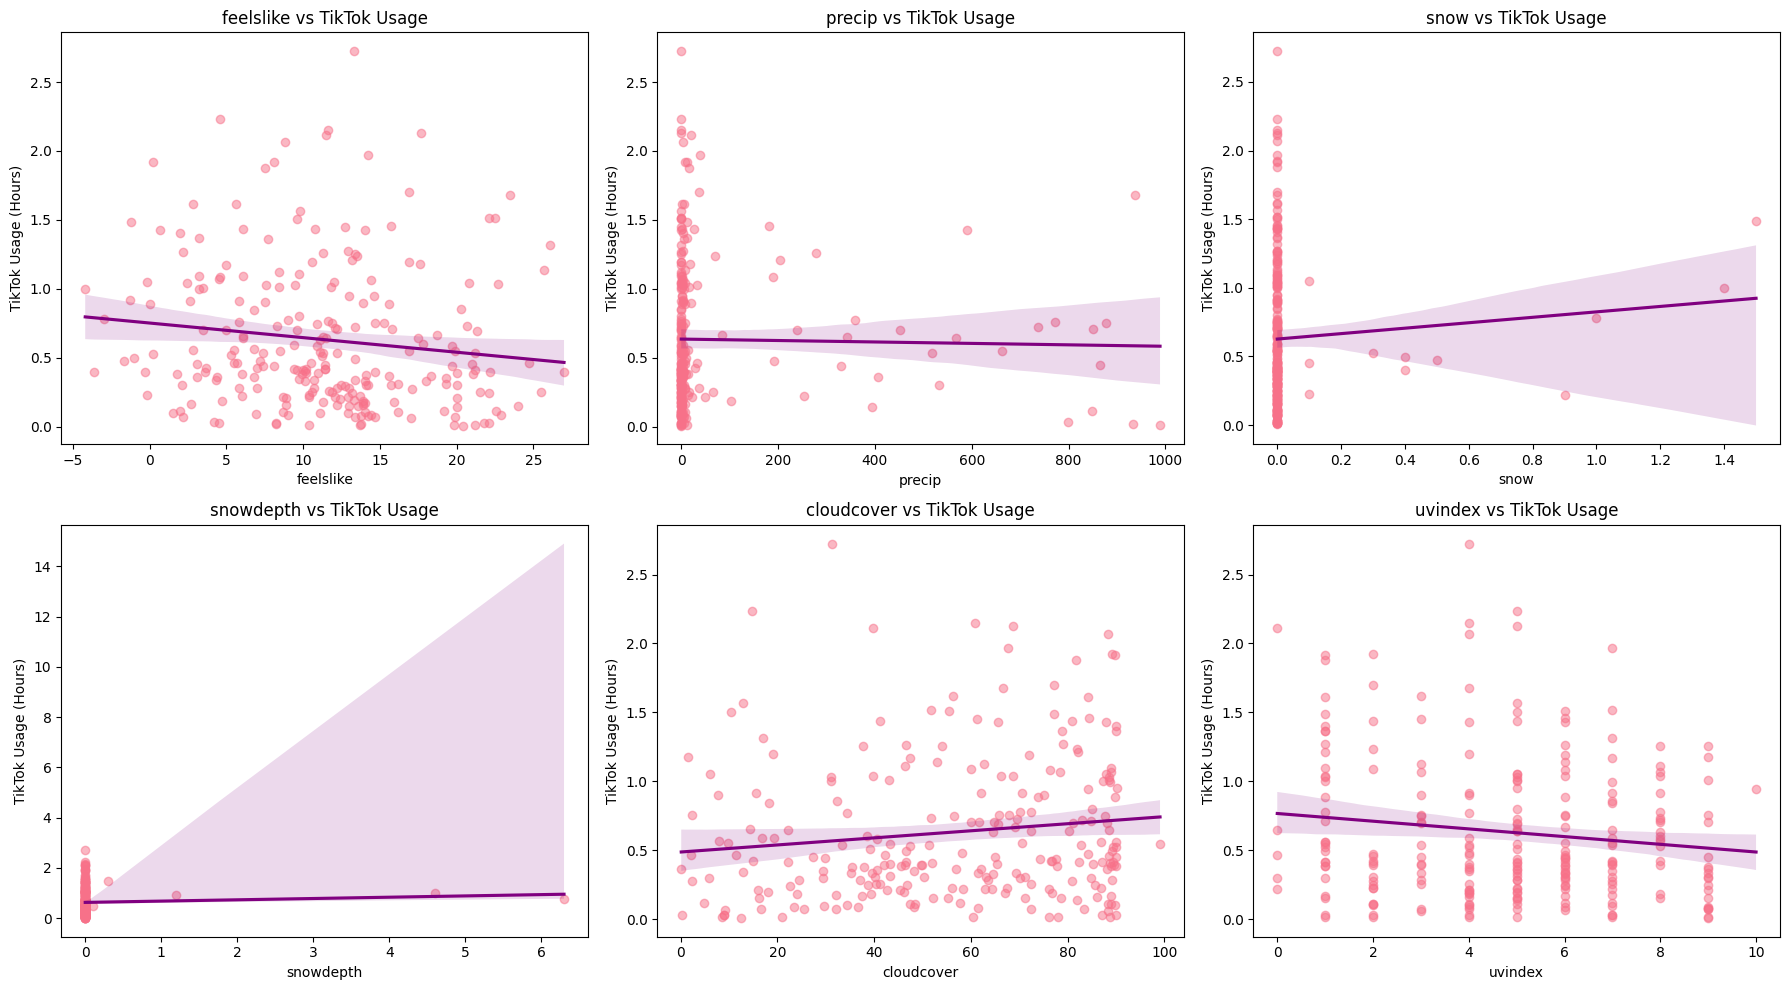

In [90]:
features = ['feelslike', 'precip', 'snow', 'snowdepth', 'cloudcover', 'uvindex']

plt.figure(figsize=(18, 10))

i = 1
for col in features:
    plt.subplot(2, 3, i)
    sns.regplot(x=col, y='TikTok Usage (Hours)', data=df,
                scatter_kws={'alpha': 0.5}, line_kws={'color': 'purple'})
    plt.title(f"{col} vs TikTok Usage")
    i += 1

plt.tight_layout()
plt.show()


## ☀️🌧️ TikTok Usage by General Weather Type
This box plot illustrates how TikTok usage varies across different weather conditions. It shows the distribution of TikTok usage hours for each general weather type, helping to identify patterns in usage based on weather.

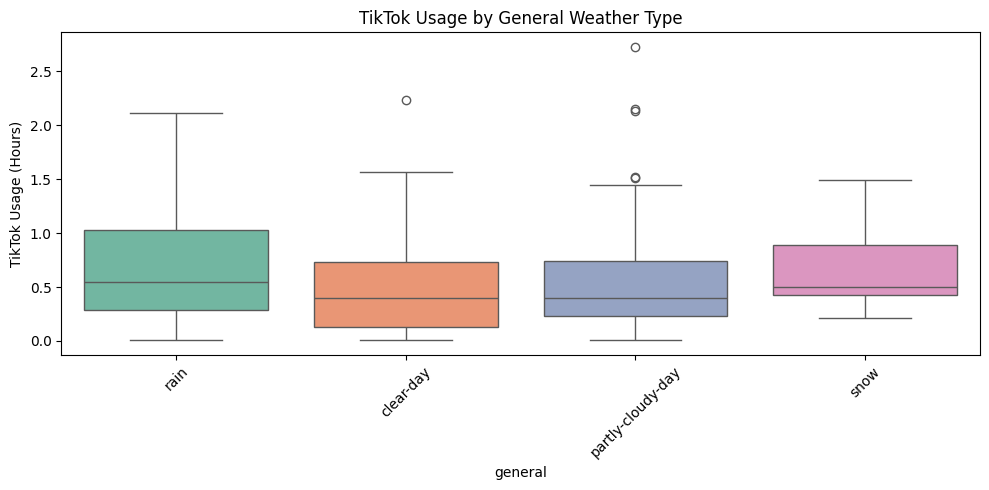

In [91]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='general', y='TikTok Usage (Hours)', data=df, hue='general', palette='Set2', legend=False)

plt.xticks(rotation=45)
plt.title("TikTok Usage by General Weather Type")

plt.tight_layout()
plt.show()


## 🎓 Academic Influence on Usage

Is my TikTok usage affected by school year?

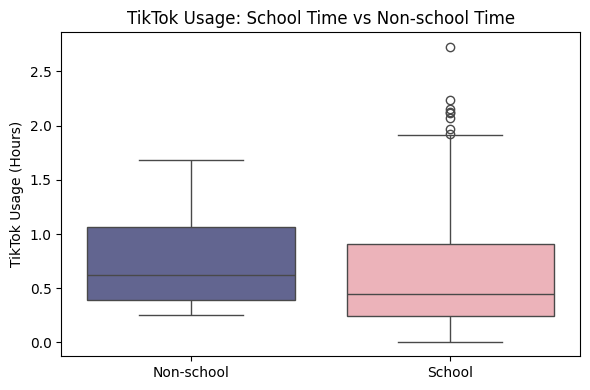

In [92]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='24/25 School Year (Bool)', y='TikTok Usage (Hours)', data=df,
            palette=['#5B5F97', '#F6A9B3'], hue='24/25 School Year (Bool)', legend=False)

plt.title("TikTok Usage: School Time vs Non-school Time")
plt.xticks([0, 1], ['Non-school', 'School'])
plt.xlabel("")

plt.tight_layout()
plt.show()


## 📆 Weekday vs Weekend TikTok Patterns

Do weekends have more TikTok engagement?


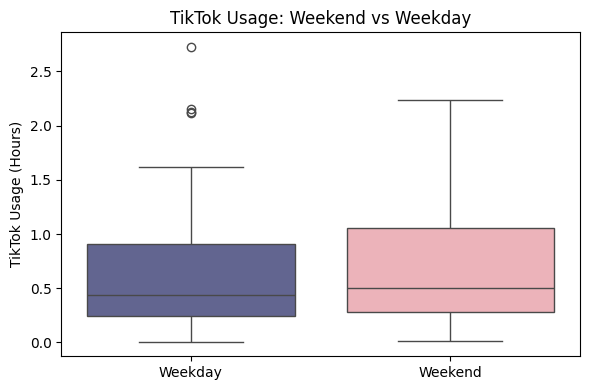

In [93]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Weekend (Bool)', y='TikTok Usage (Hours)', data=df,
            palette=['#5B5F97', '#F6A9B3'], hue='Weekend (Bool)', legend=False)

plt.title("TikTok Usage: Weekend vs Weekday")
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.xlabel("")

plt.tight_layout()
plt.show()


## 🗼Paris Fashion Week Effect
Is TikTok usage affected by fashion events?

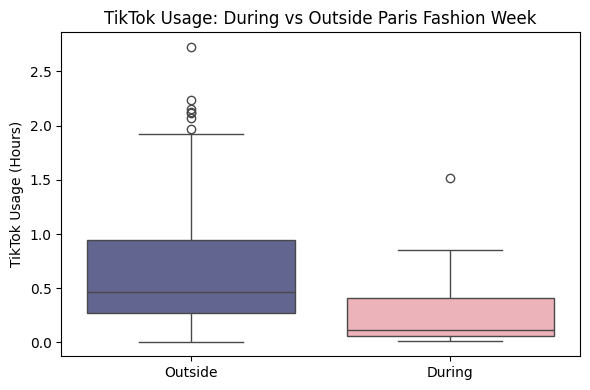

In [94]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='2024 Paris Fashion Week (Bool)', y='TikTok Usage (Hours)', data=df,
            palette=['#5B5F97', '#F6A9B3'], hue='2024 Paris Fashion Week (Bool)', legend=False)

plt.title("TikTok Usage: During vs Outside Paris Fashion Week")
plt.xticks([0, 1], ['Outside', 'During'])
plt.xlabel("")

plt.tight_layout()
plt.show()


## 🕌 Ramazan
How does the month of Ramazan affect my screen time?

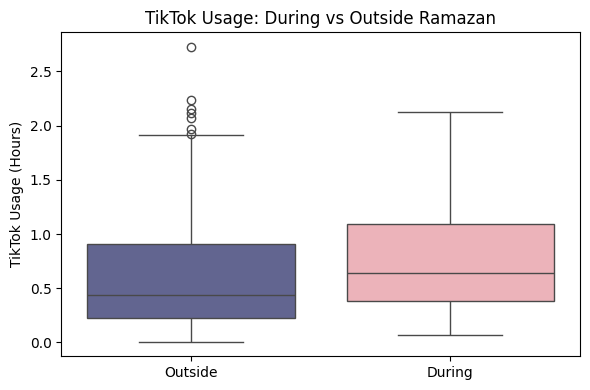

In [95]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='2025 Ramazan (Bool)', y='TikTok Usage (Hours)', data=df,
            palette=['#5B5F97', '#F6A9B3'], hue='2025 Ramazan (Bool)', legend=False)

plt.title("TikTok Usage: During vs Outside Ramazan")
plt.xticks([0, 1], ['Outside', 'During'])
plt.xlabel("")

plt.tight_layout()
plt.show()


## ⚽ Champions League
Do UEFA Champions League match days change my scrolling patterns?

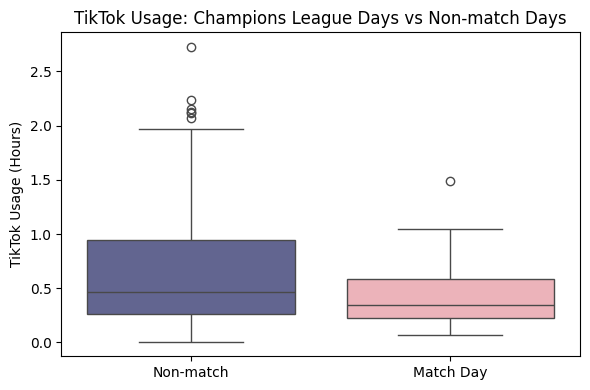

In [96]:
plt.figure(figsize=(6, 4))

#add colors as well :D
sns.boxplot(x='24/25 UEFA Champions League (Bool)', y='TikTok Usage (Hours)', data=df,
            palette=['#5B5F97', '#F6A9B3'], hue='24/25 UEFA Champions League (Bool)', legend=False)

plt.title("TikTok Usage: Champions League Days vs Non-match Days")
plt.xticks([0, 1], ['Non-match', 'Match Day'])

plt.xlabel("")

plt.tight_layout()
plt.show()


## 📊Comparing All Boolean Features Together in One Plot

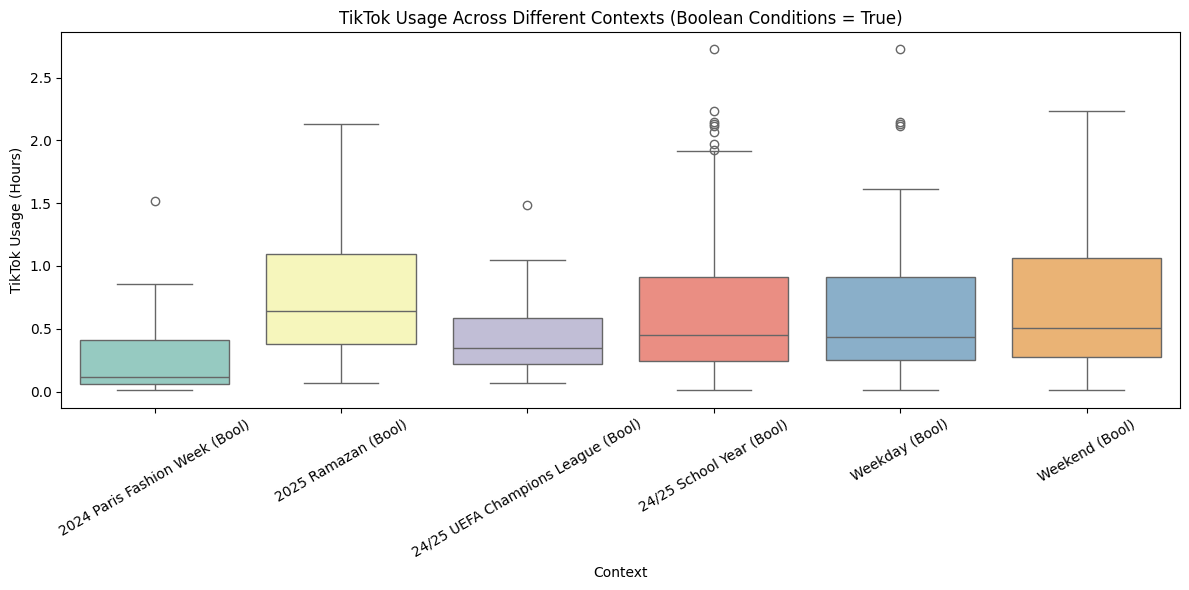

In [97]:
#Bool events
bool_cols = [
    '2024 Paris Fashion Week (Bool)', '2025 Ramazan (Bool)', '24/25 UEFA Champions League (Bool)',
    '24/25 School Year (Bool)', 'Weekday (Bool)', 'Weekend (Bool)'
]

#easier comparison
df_melted = df.melt(id_vars='TikTok Usage (Hours)',
                    value_vars=bool_cols,
                    var_name='Context',
                    value_name='isTrue')

# Only rows that are True
df_melted = df_melted[df_melted['isTrue'] == 1]

plt.figure(figsize=(12, 6))
sns.boxplot(x='Context', y='TikTok Usage (Hours)', data=df_melted, hue='Context', palette='Set3', legend=False)

plt.xticks(rotation=30)
plt.title("TikTok Usage Across Different Contexts (Boolean Conditions = True)")

plt.tight_layout()
plt.show()


## 🌍 Global Events: Do Significant International Moments Impact My Usage?

We analyze whether my engagement increases as global countdown events (like award shows or Nowruz) approach.


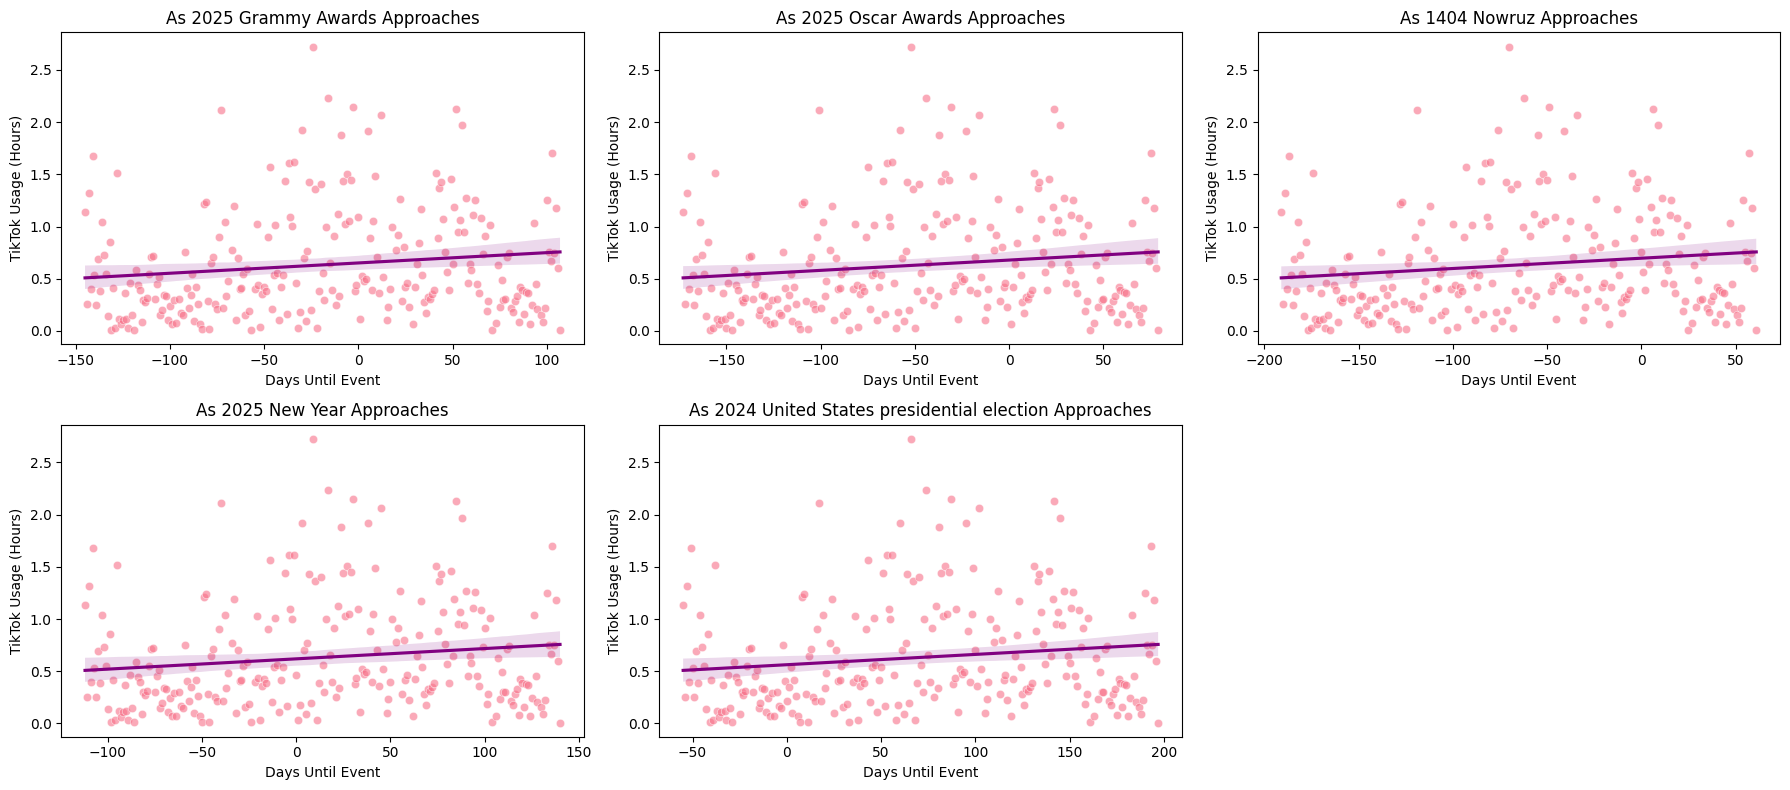

In [98]:
event_countdowns = [
    '2025 Grammy Awards (Countdown)',
    '2025 Oscar Awards (Countdown)',
    '1404 Nowruz (Countdown)',
    '2025 New Year (Countdown)',
    '2024 United States presidential election (Countdown)'
]

plt.figure(figsize=(18, 8))

i = 1
for col in event_countdowns:
    plt.subplot(2, 3, i)
    sns.scatterplot(data=df, x=-df[col], y='TikTok Usage (Hours)', alpha=0.6)
    sns.regplot(data=df, x=-df[col], y='TikTok Usage (Hours)', scatter=False, color='purple')

    event_name = col.replace('(Countdown)', '').strip()
    plt.title(f"As {event_name} Approaches")
    plt.xlabel("Days Until Event")
    plt.ylabel("TikTok Usage (Hours)")
    i += 1

plt.tight_layout()
plt.show()


## 📅 Countdown Events & TikTok Usage (Another type of graph)


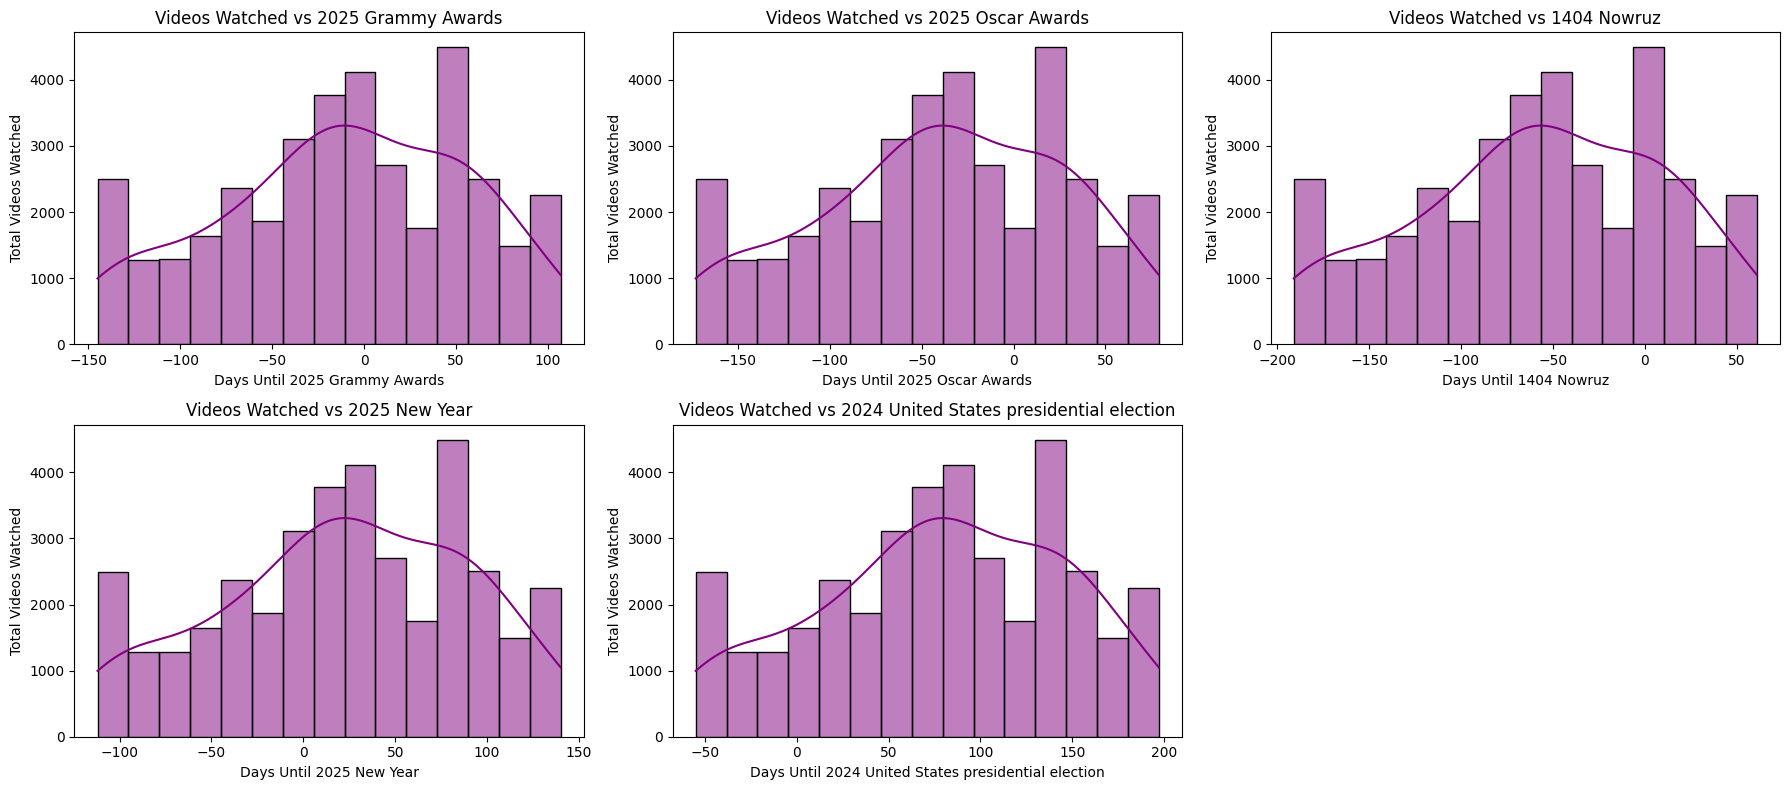

In [99]:
countdown_features = [
    '2025 Grammy Awards (Countdown)', '2025 Oscar Awards (Countdown)',
    '1404 Nowruz (Countdown)', '2025 New Year (Countdown)',
    '2024 United States presidential election (Countdown)'
]

# Multiply by -1 to get days *until* the event
df[countdown_features] = df[countdown_features] * -1

plt.figure(figsize=(18, 8))

i = 1
for col in countdown_features:
    plt.subplot(2, 3, i)
    sns.histplot(data=df, x=col, weights='Videos Watched', bins=15, kde=True, color='purple')

    event_name = col.replace('(Countdown)', '').strip()
    plt.title(f'Videos Watched vs {event_name}')
    plt.xlabel(f'Days Until {event_name}')
    plt.ylabel('Total Videos Watched')

    i += 1

plt.tight_layout()
plt.show()


# 🔍 7. Hypotheses and Results

I tested several hypotheses to explore how different factors may influence my TikTok usage. The goal was to find potential correlations between external influences (such as weather, events, and academic schedules) and my engagement with TikTok. Here are the hypotheses and their results:


In [100]:
def run_all_hypothesis_tests(df):
    def run_ttest(group1, group2, name):
        t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False, nan_policy='omit')
        sig = 'Significant' if p_val < 0.05 else 'Unfortunately Not Significant'
        print(f"{name}")
        print(f"T-statistic: {t_stat:.3f}")
        print(f"P-value: {p_val:.3f} --> {sig}\n")

    def run_corr(x, y, name):
        corr_val = x.corr(y)
        print(f"{name}")
        print(f"Correlation Coefficient: {corr_val:.3f}\n")

    print("Hypothesis Test Results\n")

    run_ttest(df[df['general'].str.contains('rain', case=False)]['Videos Watched'],
              df[~df['general'].str.contains('rain', case=False)]['Videos Watched'],
              "Rainy vs Non-Rainy Days")

    run_ttest(df[df['Weekday (Bool)'] == 1]['Videos Watched'],
              df[df['Weekend (Bool)'] == 1]['Videos Watched'],
              "Weekday vs Weekend")

    run_ttest(df[df['24/25 School Year (Bool)'] == 1]['Videos Watched'],
              df[df['24/25 School Year (Bool)'] == 0]['Videos Watched'],
              "School Year vs Vacation")

    run_ttest(df[df['24/25 UEFA Champions League (Bool)'] == 1]['Videos Watched'],
              df[df['24/25 UEFA Champions League (Bool)'] == 0]['Videos Watched'],
              "UEFA Match Days vs Normal Days")

    run_ttest(df[df['2024 Paris Fashion Week (Bool)'] == 1]['Videos Watched'],
              df[df['2024 Paris Fashion Week (Bool)'] == 0]['Videos Watched'],
              "Paris Fashion Week")

    run_ttest(df[df['2025 Ramazan (Bool)'] == 1]['Videos Watched'],
              df[df['2025 Ramazan (Bool)'] == 0]['Videos Watched'],
              "Ramazan vs Other Days")

    run_corr(df['Videos Watched'], df['2025 New Year (Countdown)'], "New Year Countdown Correlation")
    run_corr(df['Videos Watched'], df['feelslike'], "Temperature Correlation")

run_all_hypothesis_tests(df)

Hypothesis Test Results

Rainy vs Non-Rainy Days
T-statistic: 1.952
P-value: 0.052 --> Unfortunately Not Significant

Weekday vs Weekend
T-statistic: -1.426
P-value: 0.157 --> Unfortunately Not Significant

School Year vs Vacation
T-statistic: -0.896
P-value: 0.387 --> Unfortunately Not Significant

UEFA Match Days vs Normal Days
T-statistic: -2.019
P-value: 0.052 --> Unfortunately Not Significant

Paris Fashion Week
T-statistic: -1.622
P-value: 0.141 --> Unfortunately Not Significant

Ramazan vs Other Days
T-statistic: 1.570
P-value: 0.125 --> Unfortunately Not Significant

New Year Countdown Correlation
Correlation Coefficient: 0.139

Temperature Correlation
Correlation Coefficient: -0.132



*DETAILED ANALYSIS:*
---

## 🌧️ Rainy vs Non-Rainy Days  
**H1:** I watch more TikToks on rainy days.  
**Result:**  
- **T-statistic:** 1.952  
- **P-value:** 0.052 → *Not significant, but borderline.*  
- **Visual Insight:** Slightly higher usage on rainy days, suggesting a possible trend.

---

## 📅 Weekday vs Weekend  
**H2:** I spend more time on TikTok during weekends.  
**Result:**  
- **T-statistic:** -1.426  
- **P-value:** 0.157 → *Not significant*  
- **Visual Insight:** Plots suggest slightly higher usage on weekends, likely due to more free time.

---

## 🎓 School Year vs Vacation  
**H3:** I use TikTok more during breaks than in the academic year.  
**Result:**  
- **T-statistic:** -0.896  
- **P-value:** 0.387 → *Not significant*  
- **Visual Insight:** No strong pattern observed in usage between school year and vacation.

---

## ⚽ UEFA Match Days  
**H4:** I watch more TikToks during UEFA match days.  
**Result:**  
- **T-statistic:** -2.019  
- **P-value:** 0.052 → *Not significant but very close.*  
- **Visual Insight:** Plots suggest increased usage on match days, possibly due to related content trends.

---

## 👗 Paris Fashion Week  
**H5:** TikTok usage increases during Fashion Week.  
**Result:**  
- **T-statistic:** -1.622  
- **P-value:** 0.141 → *Not significant*  
- **Visual Insight:** Usage appears slightly higher during Fashion Week based on the visualizations.

---

## 🌙 Ramazan vs Other Days  
**H6:** I use TikTok more during Ramazan.  
**Result:**  
- **T-statistic:** 1.570  
- **P-value:** 0.125 → *Not significant*  
- **Visual Insight:** Some fluctuation observed, but no consistent increase during Ramazan.

---

## 🎉 New Year Countdown  
**H7:** My TikTok usage increases closer to New Year’s Eve.  
**Result:**  
- **Correlation Coefficient:** -0.139 → *Weak negative correlation*  
- **Visual Insight:** Surprisingly, usage slightly dropped near the countdown period.

---

## 🌡️ Temperature Correlation  
**H8:** I use TikTok more when it’s colder.  
**Result:**  
- **Correlation Coefficient:** -0.132 → *Weak negative correlation*  
- **Visual Insight:** Slightly more usage when temperature is between 10–15°C, but no strong trend overall.

---

## ⚠️ Final Note on Interpretation

While most of the statistical tests did not return significant p-values, several **visual patterns** (especially related to UEFA matches, Fashion Week, and weekends) suggest there might be real-world effects. These trends may become statistically significant with more data or more features. Therefore, I considered **both statistical and practical relevance** in the interpretations above.

---

#🔮 8. Prediction (ML)


This phase in this project will be training machine learning models to predict my TikTok usage based on various factors.

Note: I will try a few different models and compare their performances!!!


### Load Data

I load my dataset that has TikTok usage combined with weather and events. I recheck how many days and features it contains.


In [101]:
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
df = pd.read_csv('merged_tiktok_weather_events.csv')
print(f"Dataset loaded: {df.shape[0]} days, {df.shape[1]} features")

Dataset loaded: 245 days, 21 features


### Prepare Features and Target

I choose the columns I want to use as input features and set the target as the number of TikTok videos I watched.  
Also convert the "general weather" column into numbers so the models can understand them.


In [102]:
columns_to_remove = ['Day', 'TikTok Usage (Hours)', 'Videos Watched']
X = df.drop(columns=columns_to_remove)
y = df['Videos Watched']

# converting the only categorical variable I have
X = pd.get_dummies(X, columns=['general'], drop_first=True)

print(f"Number of features: {X.shape[1]} features")
print(f"Target variable range: {y.min()} to {y.max()} videos")


Number of features: 20 features
Target variable range: 2 to 654 videos


### Baseline Models

I create simple baseline predictors using the average and the median.
This helps me see how well my machine learning models improve over these simple guesses.


In [103]:
print("\nBASELINE MODEL PERFORMANCE\n")

baseline_mean = np.full_like(y, y.mean())
baseline_median = np.full_like(y, y.median())

baselines = {
    'Mean Predictor': baseline_mean,
    'Median Predictor': baseline_median,
}

baseline_results = {}
for name, pred in baselines.items():
    mae = mean_absolute_error(y, pred)
    mse = mean_squared_error(y, pred)
    baseline_results[name] = {'MAE': mae, 'MSE': mse}
    print(f"{name:15}: MAE = {mae:6.2f}, MSE = {mse:8.2f}")

best_baseline_mae = min([result['MAE'] for result in baseline_results.values()])



BASELINE MODEL PERFORMANCE

Mean Predictor : MAE =  98.79, MSE = 15475.02
Median Predictor: MAE =  93.46, MSE = 17292.85


### Machine Learning Models and Cross-Validation

I try some models like Linear Regression, Decision Tree, Random Forest, and K-Nearest Neighbors.  
Will use time-based cross-validation to check how good each model is at predicting my TikTok usage.


In [104]:
print(f"\nMACHINE LEARNING MODELS\n")

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
}

tscv = TimeSeriesSplit(n_splits=5)
cv_results = {}

print("Cross-Validation Results:")
for name, model in models.items():
    cv_mae_scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_absolute_error')
    cv_mse_scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error')
    cv_r2_scores = cross_val_score(model, X, y, cv=tscv, scoring='r2')

    cv_results[name] = {
        'MAE_mean': -cv_mae_scores.mean(),
        'MAE_std': cv_mae_scores.std(),
        'MSE_mean': -cv_mse_scores.mean(),
        'R2_mean': cv_r2_scores.mean(),
        'R2_std': cv_r2_scores.std()
    }

    print(f"{name:20}: MAE = {-cv_mae_scores.mean():6.2f} ± {cv_mae_scores.std():5.2f}")



MACHINE LEARNING MODELS

Cross-Validation Results:
Linear Regression   : MAE = 134.05 ± 33.11
Decision Tree       : MAE = 151.38 ± 37.99
Random Forest       : MAE = 114.21 ± 22.93
K-Nearest Neighbors : MAE = 108.22 ± 17.82


### Train-Test Split and Model Evaluation

I split my data into training and testing sets without mixing the order of days.  
Then, trained each model and test how well they predict unseen data.  
I later calculate different scores like MAE and R² to compare their performance to the baselines.


In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

detailed_results = {}
predictions = {}

print(f"\nDETAILED TEST SET EVALUATION\n")

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    detailed_results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Better_than_baseline': mae < best_baseline_mae
    }

    predictions[name] = y_pred

    print(f"{name:20}: MAE={mae:6.2f}, RMSE={rmse:6.2f}, R²={r2:6.3f} {'good' if mae < best_baseline_mae else 'bad'}")



DETAILED TEST SET EVALUATION

Linear Regression   : MAE=231.40, RMSE=253.89, R²=-6.147 bad
Decision Tree       : MAE=294.37, RMSE=323.20, R²=-10.581 bad
Random Forest       : MAE=179.23, RMSE=204.20, R²=-3.623 bad
K-Nearest Neighbors : MAE=179.01, RMSE=202.03, R²=-3.525 bad


###👉 Visualization of Results

I created charts to compare the models:  
- Bar charts for error and accuracy  
- A scatter plot showing actual vs predicted values for the best model  
- A plot of prediction errors  
- A time plot showing actual and predicted TikTok usage over days  

This helps me understand which model works best and how accurate it is.


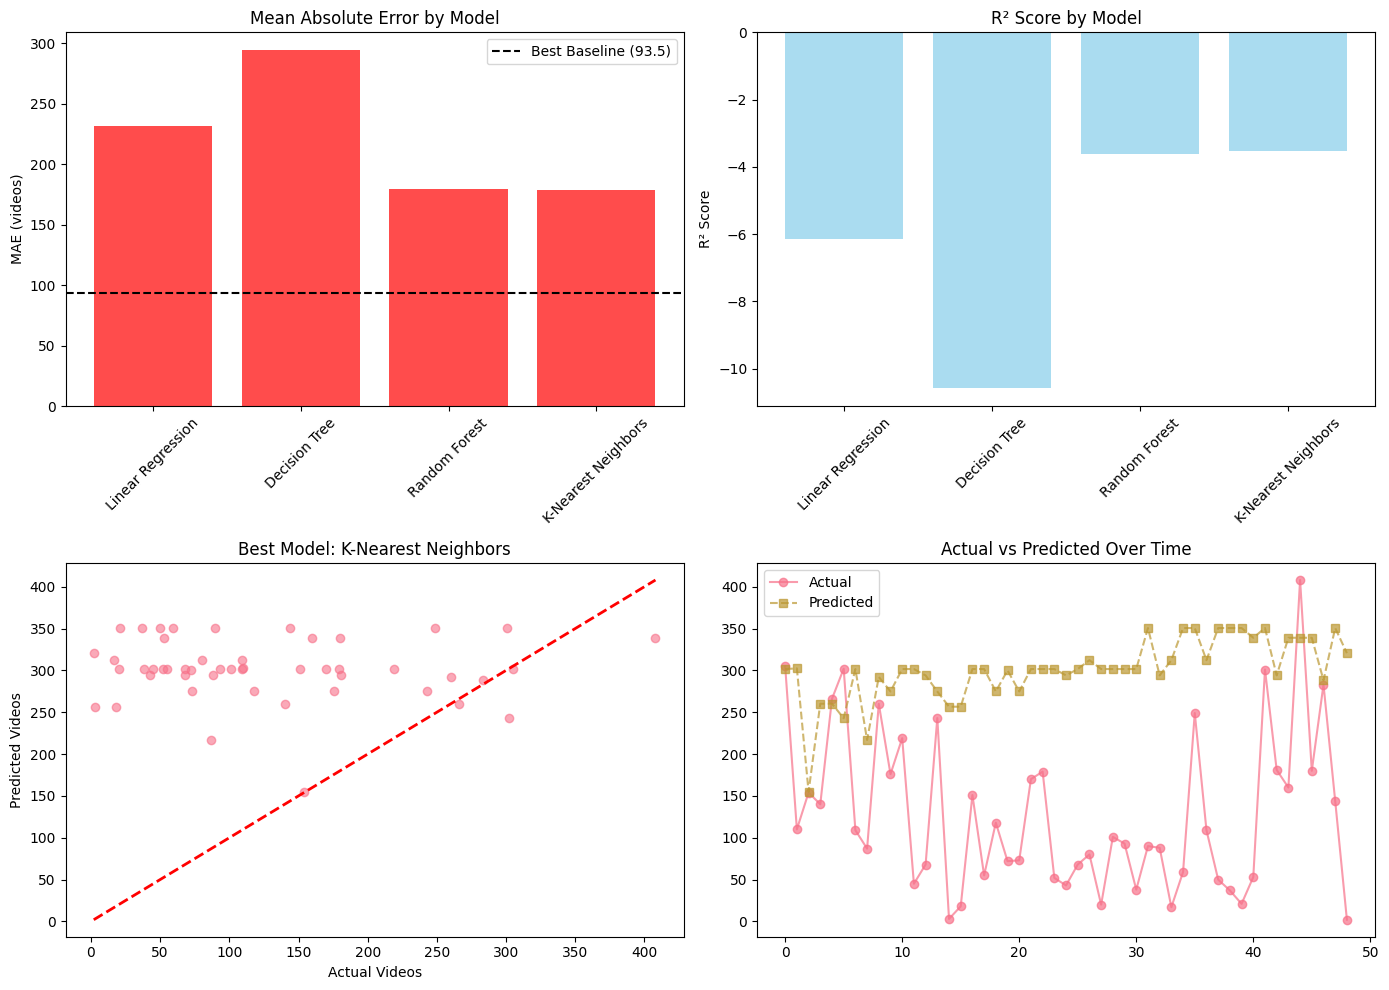

In [106]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

model_names = list(detailed_results.keys())
mae_values = [detailed_results[name]['MAE'] for name in model_names]
colors = ['green' if mae < best_baseline_mae else 'red' for mae in mae_values]

# MAE Plot
axes[0, 0].bar(model_names, mae_values, color=colors, alpha=0.7)
axes[0, 0].axhline(y=best_baseline_mae, color='black', linestyle='--', label=f'Best Baseline ({best_baseline_mae:.1f})')
axes[0, 0].set_title('Mean Absolute Error by Model')
axes[0, 0].set_ylabel('MAE (videos)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].legend()

# R² Plot
r2_values = [detailed_results[name]['R2'] for name in model_names]
axes[0, 1].bar(model_names, r2_values, color='skyblue', alpha=0.7)
axes[0, 1].set_title('R² Score by Model')
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].tick_params(axis='x', rotation=45)

# Best model plot
best_model_name = min(detailed_results.keys(), key=lambda x: detailed_results[x]['MAE'])
best_predictions = predictions[best_model_name]
axes[1, 0].scatter(y_test, best_predictions, alpha=0.6)
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual Videos')
axes[1, 0].set_ylabel('Predicted Videos')
axes[1, 0].set_title(f'Best Model: {best_model_name}')

# Predictions plot
axes[1, 1].plot(range(len(y_test)), y_test, 'o-', label='Actual', alpha=0.7)
axes[1, 1].plot(range(len(y_test)), best_predictions, 's--', label='Predicted', alpha=0.7)
axes[1, 1].legend()
axes[1, 1].set_title('Actual vs Predicted Over Time')

plt.tight_layout()
plt.show()


#⭐ Conclusion

Found that my baseline models, especially the Median Predictor, gave me a pretty good starting point with an MAE around 93 videos.  
However, the machine learning models I tried didn’t perform better on the test set — their errors were actually higher, and the R² scores were negative.  
This means the models struggled to predict my TikTok usage accurately with the current features and data.

🍀 I aim to try to advance my project in the future with:
- Collecting more data or more relevant features,
- Trying other models

For now, the simple baseline remains my best guess. 🌸
